In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
table = pd.read_excel('lr2.xlsx')
# Исходные данные 12-го варианта
table12 = pd.concat([
    table[7:11],
    table[12:25],
    table[32:37],
    table[38:46],
    table[72:78],
    table[79:],
])
X = table12.iloc[:,1:-1]
Ybin = table12.iloc[:,-1]

In [3]:
# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(X, Ybin, test_size=0.15, random_state=42, stratify=Ybin)

print(y_train.count(), y_train.mean())
print(y_test.count(), y_test.mean())

39 0.358974358974359
7 0.2857142857142857


<Axes: >

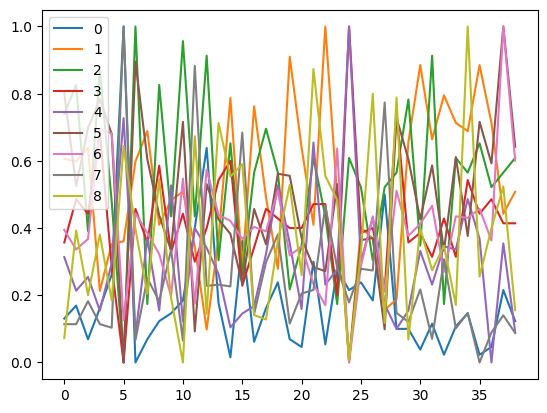

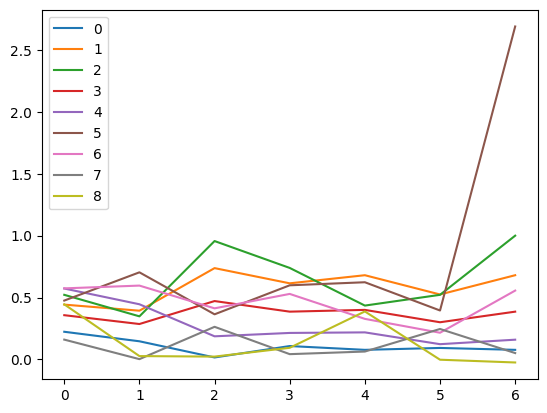

In [4]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(x_train)
# Transform both the training and testing data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

pd.DataFrame(x_train).plot()
pd.DataFrame(x_test).plot()

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Определение параметров для сетки поиска
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Создание и настройка модели kNN
knn = KNeighborsClassifier()

# Использование GridSearchCV для поиска наилучшего числа соседей
grid_search = GridSearchCV(knn, param_grid)
grid_search.fit(x_train, y_train)

y_pred_knn_train = grid_search.predict(x_train)
y_pred_knn_test = grid_search.predict(x_test)

# Вывод наилучшего параметра числа соседей
print("Лучший параметр и точность: ", grid_search.best_params_['n_neighbors'], grid_search.best_score_ )

Лучший параметр и точность:  1 0.7178571428571429


In [54]:
# Определение параметров для сетки поиска
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', None]}

# Создание и настройка модели логистической регрессии
logreg = LogisticRegression()

# Использование GridSearchCV для поиска наилучшего параметра регуляризации
grid_search = GridSearchCV(logreg, param_grid)
grid_search.fit(x_train, y_train)

y_pred_logreg_train_float = grid_search.predict_proba(x_train)[:, 1]
y_pred_logreg_test_float = grid_search.predict_proba(x_test)[:, 1]

y_pred_logreg_train = grid_search.predict(x_train)
y_pred_logreg_test = grid_search.predict(x_test)

logreg_coef = grid_search.best_estimator_.coef_[0]

# Вывод наилучшего параметра регуляризации
print("Лучший параметр и точность: ", grid_search.best_params_['penalty'], grid_search.best_score_)

Лучший параметр и точность:  l2 0.6428571428571429


In [7]:
from sklearn.tree import DecisionTreeClassifier

# Определение параметров для сетки поиска
param_grid = {'max_depth': list(range(1, 20))}

# Создание и настройка модели дерева решений
tree = DecisionTreeClassifier()

# Использование GridSearchCV для поиска наилучшей глубины дерева
grid_search = GridSearchCV(tree, param_grid)
grid_search.fit(x_train, y_train)

y_pred_tree_train = grid_search.predict(x_train)
y_pred_tree_test = grid_search.predict(x_test)

tree_coef = grid_search.best_estimator_.feature_importances_

# Вывод наилучшей глубины дерева
print("Лучший параметр и точность: ", grid_search.best_params_['max_depth'], grid_search.best_score_)

Лучший параметр и точность:  18 0.6107142857142857


In [57]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve

# Вычисление метрик для kNN
data_knn = {
    'Type': ['knn_train', 'knn_test'],
    'Accuracy': [accuracy_score(y_train, y_pred_knn_train), accuracy_score(y_test, y_pred_knn_test)], 
    'ROC-AUC': [roc_auc_score(y_train, y_pred_knn_train, multi_class='ovr'), roc_auc_score(y_test, y_pred_knn_test, multi_class='ovr')], 
    'Precision': [precision_score(y_train, y_pred_knn_train, average='macro'), precision_score(y_test, y_pred_knn_test, average='macro')], 
    'Recall': [recall_score(y_train, y_pred_knn_train, average='macro'), recall_score(y_test, y_pred_knn_test, average='macro')], 
    'F1': [f1_score(y_train, y_pred_knn_train, average='macro'), f1_score(y_test, y_pred_knn_test, average='macro')]
}

# Вычисление метрик для логистической регрессии
fpr, tpr, thresholds = roc_curve(y_train, y_pred_logreg_train_float)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
data_logreg = {
    'Type': ['logreg_train', 'logreg_test'],
    'Accuracy': [accuracy_score(y_train, y_pred_logreg_train), accuracy_score(y_test, y_pred_logreg_test)], 
    'ROC-AUC': [roc_auc_score(y_train, y_pred_logreg_train_float, max_fpr=optimal_threshold), 
                roc_auc_score(y_test, y_pred_logreg_test_float, max_fpr=optimal_threshold)], 
    'Precision': [precision_score(y_train, y_pred_logreg_train, average='macro'), precision_score(y_test, y_pred_logreg_test, average='macro')], 
    'Recall': [recall_score(y_train, y_pred_logreg_train, average='macro'), recall_score(y_test, y_pred_logreg_test, average='macro')], 
    'F1': [f1_score(y_train, y_pred_logreg_train, average='macro'), f1_score(y_test, y_pred_logreg_test, average='macro')]
}

# Вычисление метрик для Дерева решений
data_tree = {
    'Type': ['tree_train', 'tree_test'],
    'Accuracy': [accuracy_score(y_train, y_pred_tree_train), accuracy_score(y_test, y_pred_tree_test)], 
    'ROC-AUC': [roc_auc_score(y_train, y_pred_tree_train, multi_class='ovr'), roc_auc_score(y_test, y_pred_tree_test, multi_class='ovr')], 
    'Precision': [precision_score(y_train, y_pred_tree_train, average='macro'), precision_score(y_test, y_pred_tree_test, average='macro')], 
    'Recall': [recall_score(y_train, y_pred_tree_train, average='macro'), recall_score(y_test, y_pred_tree_test, average='macro')], 
    'F1': [f1_score(y_train, y_pred_tree_train, average='macro'), f1_score(y_test, y_pred_tree_test, average='macro')]
}

print(pd.concat([pd.DataFrame(data_knn), pd.DataFrame(data_logreg), pd.DataFrame(data_tree)]))

           Type  Accuracy  ROC-AUC  Precision  Recall   F1
0     knn_train      1.00     1.00       1.00    1.00 1.00
1      knn_test      0.43     0.45       0.46    0.45 0.42
0  logreg_train      0.64     0.75       0.32    0.50 0.39
1   logreg_test      0.71     0.39       0.36    0.50 0.42
0    tree_train      1.00     1.00       1.00    1.00 1.00
1     tree_test      0.57     0.55       0.54    0.55 0.53


In [58]:
importances = pd.Series(np.abs(logreg_coef), index=X.columns) 
feature_importances_tree = pd.Series(tree_coef, index=X.columns) 
importances_df = pd.concat([importances, feature_importances_tree], axis=1, sort=False) 
importances_df.columns = ['LogReg', 'Decision Tree']

print(importances_df)

    LogReg  Decision Tree
х1    0.44           0.25
х2    0.26           0.19
х3    0.50           0.16
х4    0.70           0.00
х5    0.41           0.17
х6    0.00           0.08
x7    0.16           0.00
x8    0.33           0.00
x9    0.17           0.15
